# Restaurant Recommendation System

## 2. Exploratory Data Analysis (EDA)

## Aim
After getting our data ready, we still want to make sense of it. In EDA we look at various plots and actually let the data tell us its story. This step will give us a deeper understanding of data. We'll also try to make data more amenable to modelling. We'll look at various table in database.

We'll be using matplolib and seaborn to make various plots.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras


from time import time
from IPython.display import clear_output
from collections import OrderedDict

plt.style.use('ggplot')

In [2]:
# Functions to work with SQLite db
def make_query(sel):
    """Query database"""
    c = db.cursor().execute(sel)
    return c.fetchall()

def make_frame(list_of_tuples=None, legend=[], query=None):
    """
    Returns DataFrame from a query or result of query
    """
    framelist=[]
    if list_of_tuples is None:
        if query is None:
            print("Error: No query made")
            return
        list_of_tuples = make_query(query)
        
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist))

# Connect to database
db = sq3.connect('../input/yelp-project/yelp_database.db')

### Reviews Table

In [3]:
# Looking at columns of 'reviews' table
make_query("PRAGMA table_info(reviews)")

[(0, 'review_id', 'VARCHAR', 0, None, 1),
 (1, 'user_id', 'INTEGER', 0, None, 0),
 (2, 'business_id', 'INTEGER', 0, None, 0),
 (3, 'stars', 'FLOAT', 0, None, 0),
 (4, 'useful', 'INTEGER', 0, None, 0),
 (5, 'funny', 'INTEGER', 0, None, 0),
 (6, 'cool', 'INTEGER', 0, None, 0),
 (7, 'text', 'VARCHAR', 0, None, 0),
 (8, 'date', 'TIMESTAMP', 0, None, 0)]

In [4]:
%%time
# Getting pandas DataFrame from db
date_df = make_frame(query="SELECT stars, date FROM reviews", legend=['rating', 'date'])
date_df.date = pd.to_datetime(date_df.date)
date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5509524 entries, 0 to 5509523
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   rating  float64       
 1   date    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 84.1 MB
CPU times: user 17.2 s, sys: 6.9 s, total: 24.1 s
Wall time: 1min 29s


In [5]:
# Creating new columns in reviews df
date_df['day'] = date_df.date.dt.day
date_df['month'] = date_df.date.dt.month
date_df['year'] = date_df.date.dt.year
date_df['hour'] = date_df.date.dt.hour
date_df['minute'] = date_df.date.dt.minute
date_df['second'] = date_df.date.dt.second

date_df.head()

,rating,date,day,month,year,hour,minute,second
0,5.0,2015-12-05 03:18:11,5,12,2015,3,18,11
1,1.0,2011-05-27 05:30:52,27,5,2011,5,30,52
2,4.0,2017-01-14 21:56:57,14,1,2017,21,56,57
3,5.0,2013-05-07 07:25:25,7,5,2013,7,25,25
4,5.0,2015-11-05 23:11:05,5,11,2015,23,11,5


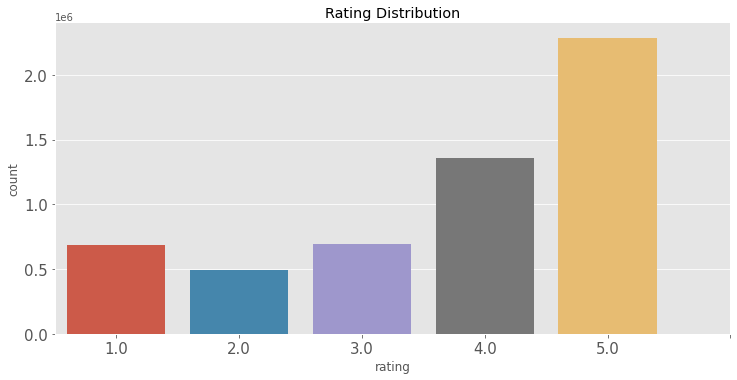

In [6]:
sns.catplot(data=date_df, x='rating', kind='count', aspect=2)
ax = plt.gca()
ax.set(xticks=[0,1,2,3,4,5], title='Rating Distribution')
ax.tick_params('x', labelsize=15)
ax.tick_params('y', labelsize=15)

We see many most ratings are on the higher scale. Most ratings are either 5 star or 4 star.

Text(0.5, 1.0, 'Number of reviews by Year')

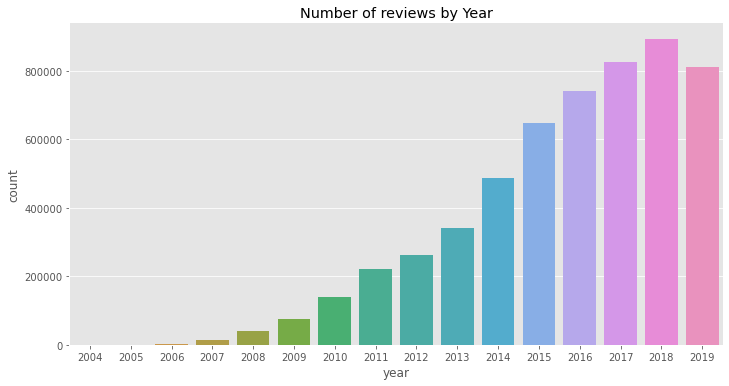

In [7]:
g = sns.catplot(data=date_df, x='year', kind='count', aspect=2)
ax = plt.gca()
ax.set_title('Number of reviews by Year')

We see number of reviews increased exponentially over the years. This could also be an evidence for yelp's popularity over the years.

Text(0.5, 1.0, 'Ratings by Month')

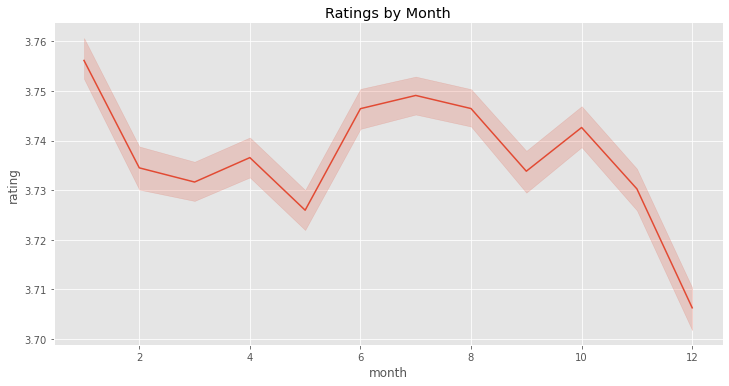

In [8]:
g = sns.relplot(data=date_df, x='month', y='rating', aspect=2, kind='line')
ax = plt.gca()
ax.set_title('Ratings by Month')

We see that average rating after faceting on month is minimum for 12th month ~ December. But if we look at the y-scale, change is not so significant to draw a trend.

Text(0.5, 1.0, 'Ratings by Day')

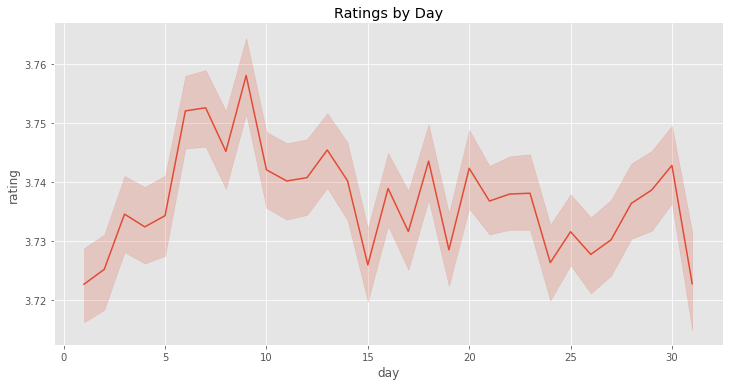

In [9]:
g = sns.relplot(data=date_df, x='day', y='rating', aspect=2, kind='line')
ax = plt.gca()
ax.set_title('Ratings by Day')

We see that average rating after faceting on day is max from 5th to 10th day. But if we look at the y-scale, change is not so significant to draw a trend.

Text(0.5, 1.0, 'Review Time')

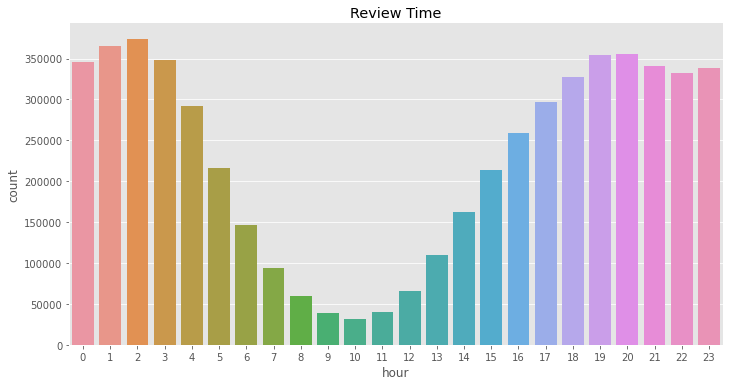

In [10]:
sns.catplot(data=date_df, x='hour', aspect=2, kind='count')
ax = plt.gca()
ax.set_title('Review Time')

This is interesting as we see minimum number of reviews were given during morning and count keeps rising throughout the day which seems intuitive. But maximum number of reviews were given at 2am which is counter intuitive. Why are more people reviewing this late? Is it possible that these are bars where people stay for long but why would drunks care about reviewing? Or are people reviewing after dinner during their commute home? We would have to look at further evidence to draw conclusions.

In [11]:
#Release memory
del date_df

### Users Table

In [12]:
#Looking at columns and making a DataFrame from users table
cols = list(zip(*make_query("PRAGMA table_info(users)")))[1]
users_df = make_frame(query='SELECT * FROM users;', legend=cols)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968703 entries, 0 to 1968702
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             int64  
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(17), object(4)
memory usage: 330.4+ MB


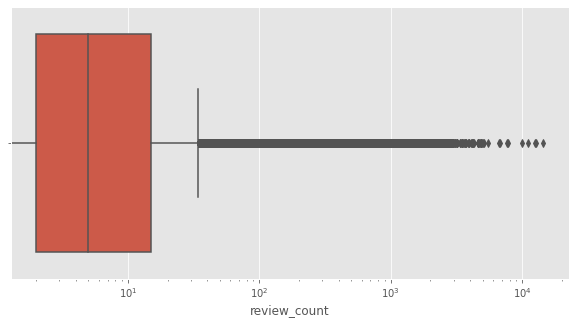

In [13]:
plt.figure(figsize=(10,5))
ax = plt.gca()
sns.boxplot(data=users_df, x='review_count', ax=ax)
plt.xscale('log')

The boxplot for review count reveals a lot of outliers. There are some users who have written over 10k reviews.

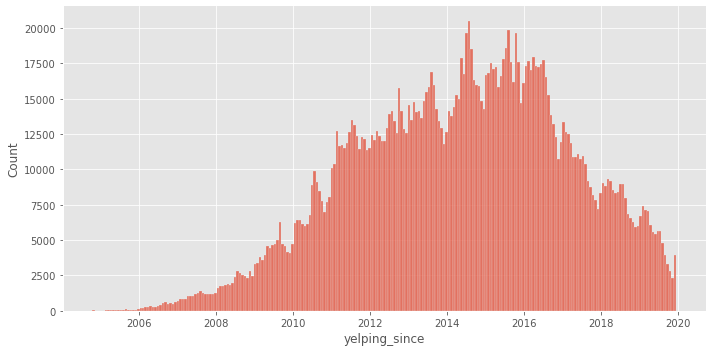

In [14]:
#Type Cast to datetime format
users_df.yelping_since = pd.to_datetime(users_df.yelping_since)
sns.displot(data=users_df, x='yelping_since', aspect=2)

Most people are yelping_since mid 2010s.

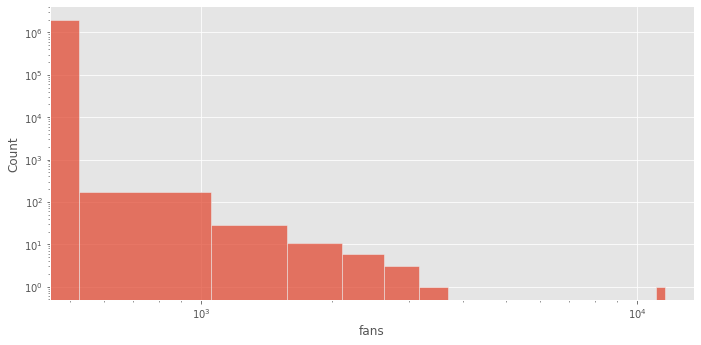

In [15]:
sns.displot(data=users_df, x='fans', aspect=2)
plt.xscale('log')
plt.yscale('log')

Some users are wildly popular reviewers on yelp. Most people have few or no fans

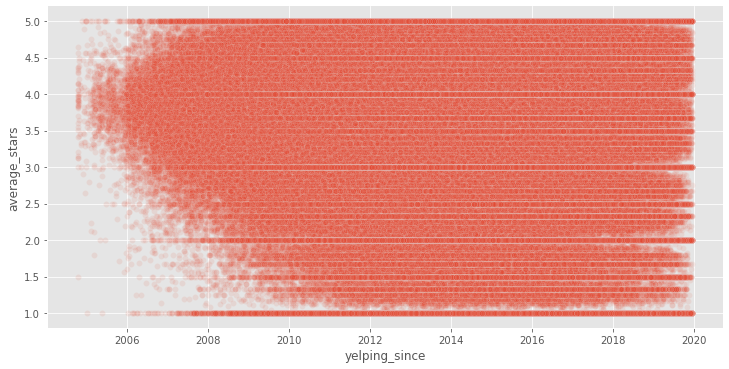

In [16]:
sns.relplot(data=users_df, x='yelping_since', y='average_stars',alpha=.1, aspect=2)

We see that reviewers who have been yelping for long have higher avg rating. We can conclude that overtime users become less harsh reviewers.

In [17]:
#Release Memory
del users_df

### Businesses table

In [18]:
# Looking at business table's columns and theirdtypes
make_query("PRAGMA table_info(businesses)")

[(0, 'business_id', 'INTEGER', 1, None, 1),
 (1, 'name', 'VARCHAR', 0, None, 0),
 (2, 'address', 'VARCHAR', 0, None, 0),
 (3, 'city', 'VARCHAR', 0, None, 0),
 (4, 'state', 'VARCHAR', 0, None, 0),
 (5, 'postal_code', 'VARCHAR', 0, None, 0),
 (6, 'latitude', 'FLOAT', 0, None, 0),
 (7, 'longitude', 'FLOAT', 0, None, 0),
 (8, 'stars', 'FLOAT', 0, None, 0),
 (9, 'review_count', 'INTEGER', 0, None, 0),
 (10, 'is_open', 'BOOLEAN', 0, None, 0),
 (11, 'categories', 'VARCHAR', 0, None, 0),
 (12, 'RestaurantsAttire', 'BOOLEAN', 0, None, 0),
 (13, 'RestaurantsTakeOut', 'BOOLEAN', 0, None, 0),
 (14, 'BusinessAcceptsCreditCards', 'BOOLEAN', 0, None, 0),
 (15, 'NoiseLevel', 'BOOLEAN', 0, None, 0),
 (16, 'GoodForKids', 'BOOLEAN', 0, None, 0),
 (17, 'RestaurantsReservations', 'BOOLEAN', 0, None, 0),
 (18, 'RestaurantsGoodForGroups', 'BOOLEAN', 0, None, 0),
 (19, 'BusinessParking', 'BOOLEAN', 0, None, 0),
 (20, 'RestaurantsPriceRange2', 'BOOLEAN', 0, None, 0),
 (21, 'HasTV', 'BOOLEAN', 0, None, 0),
 (22

In [19]:
#Getting dataframe from table
business_df_cols = list(zip(*make_query("PRAGMA table_info(businesses)")))[1]
business_df = make_frame(query='SELECT * FROM businesses', legend=business_df_cols)
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,RestaurantsCounterService,Open24Hours,HairSpecializesIn,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,The Empanadas House,404 E Green St,Champaign,IL,61820,40.110446,-88.233073,4.5,5,...,0,0,0,11:30-14:30,11:30-14:30,11:30-14:30,11:30-14:30,11:30-14:30,None,None
1,1,Chocolate Shoppe Ice Cream,2831 Parmenter St,Middleton,WI,53562,43.105310,-89.510142,3.5,6,...,0,0,0,0:0-0:0,11:0-21:0,11:0-21:0,11:0-21:0,11:0-22:0,11:0-22:0,11:0-21:0
2,2,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,...,0,0,0,None,None,None,None,None,None,None
3,3,Tipsy Ryde,,Gastonia,NC,28054,35.252842,-81.152698,3.5,3,...,0,0,0,0:0-0:0,9:0-0:0,9:0-0:0,9:0-0:0,9:0-2:30,9:0-2:30,12:0-0:0
4,4,Philthy Phillys,"15480 Bayview Avenue, unit D0110",Aurora,ON,L4G 7J1,44.010962,-79.448677,4.5,4,...,0,0,0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-21:0


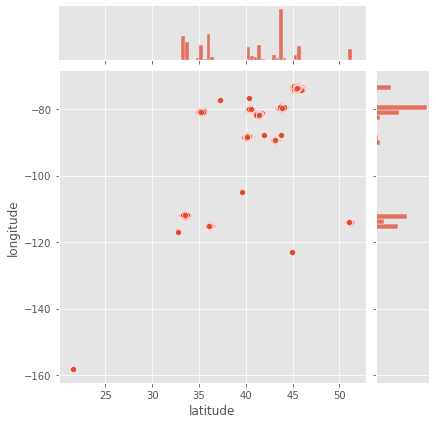

In [20]:
sns.jointplot(data=business_df, x='latitude', y='longitude')

We see that locations of businesses are concentrated in clusters. These clusters must be big cities. Lets plot these on a map.

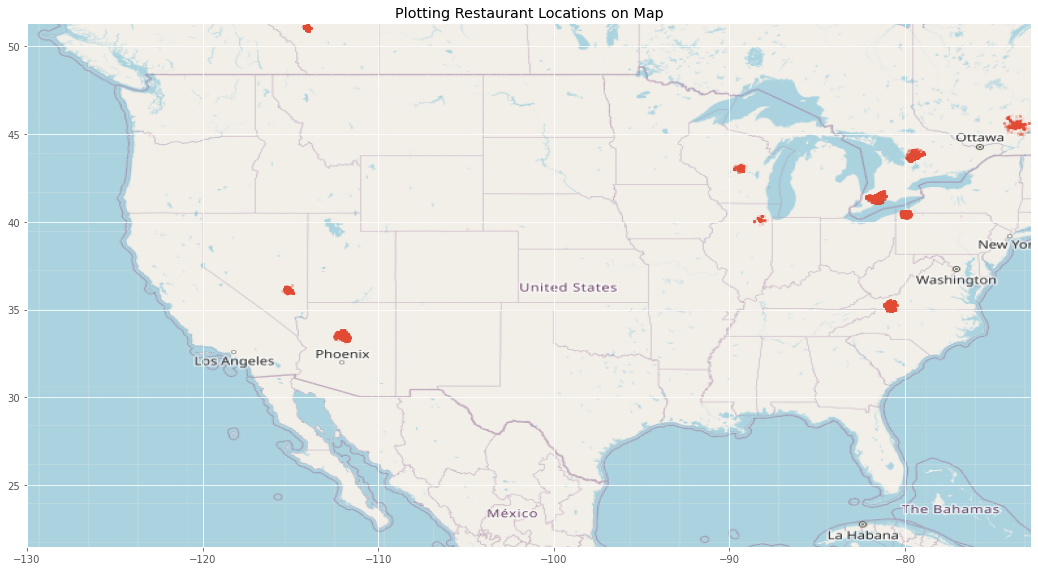

In [21]:
BBox = (business_df.longitude.min(),   business_df.longitude.max(), business_df.latitude.min(), business_df.latitude.max())

img = plt.imread('../input/map-img-for-yelp-business-df/map(1).png')[:,:,:-1]
fig, ax = plt.subplots(figsize = (18,14))
ax.scatter(business_df.longitude, business_df.latitude, zorder=1, alpha= 0.1, s=5)
ax.set_title('Plotting Restaurant Locations on Map')
ax.set_xlim(-130,BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(img, zorder=0, extent = BBox, aspect='equal')

We see our data has businesses from certain cities of U.S. and not all over U.S.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 576x576 with 0 Axes>

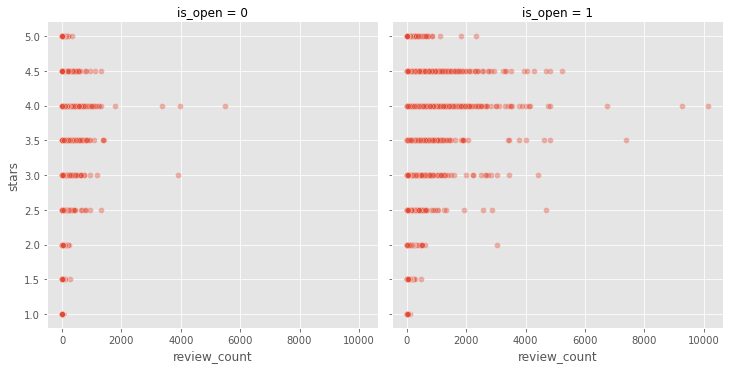

<Figure size 576x576 with 0 Axes>

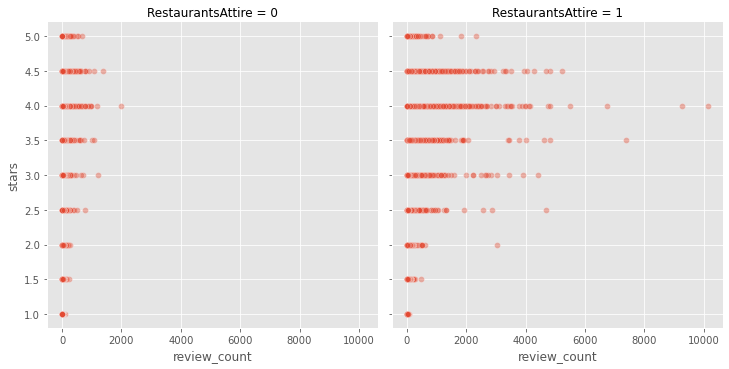

<Figure size 576x576 with 0 Axes>

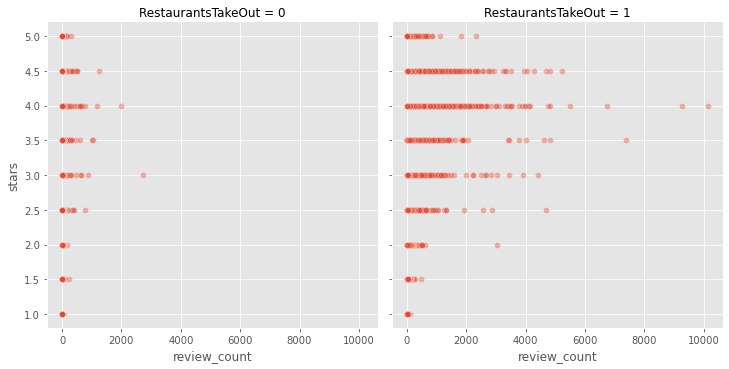

<Figure size 576x576 with 0 Axes>

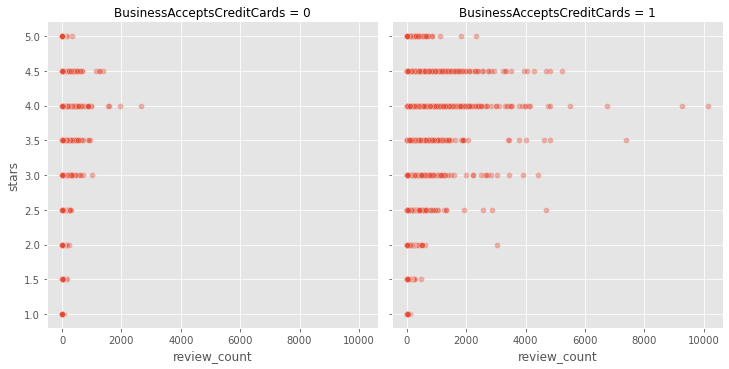

<Figure size 576x576 with 0 Axes>

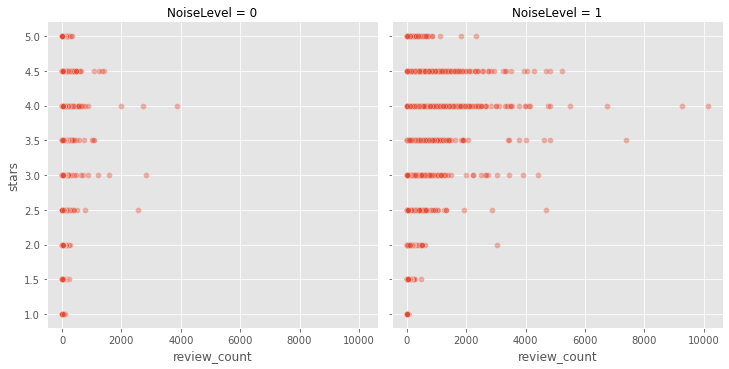

<Figure size 576x576 with 0 Axes>

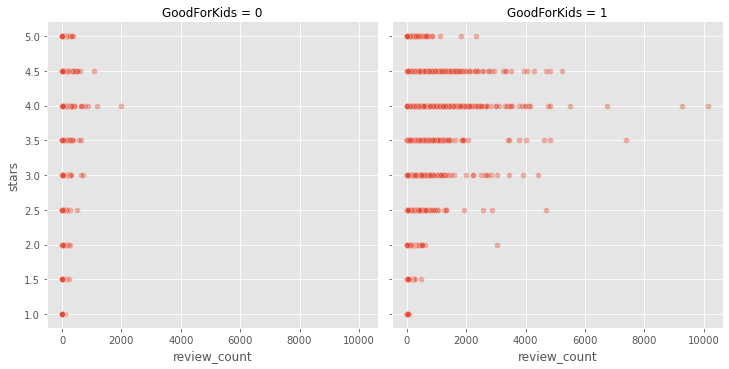

<Figure size 576x576 with 0 Axes>

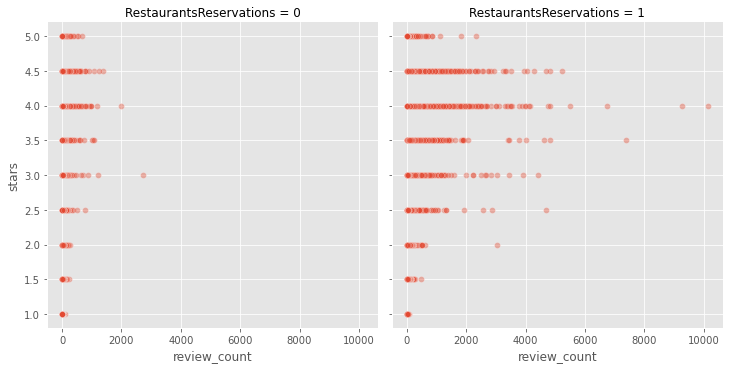

<Figure size 576x576 with 0 Axes>

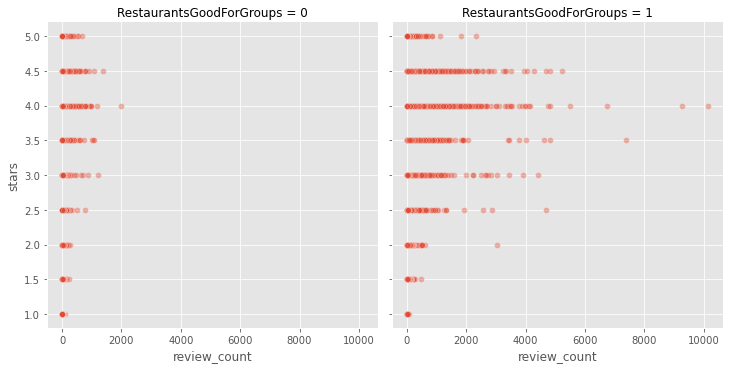

<Figure size 576x576 with 0 Axes>

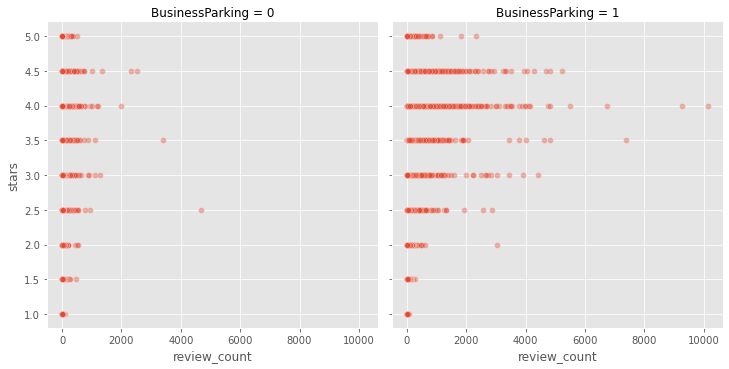

<Figure size 576x576 with 0 Axes>

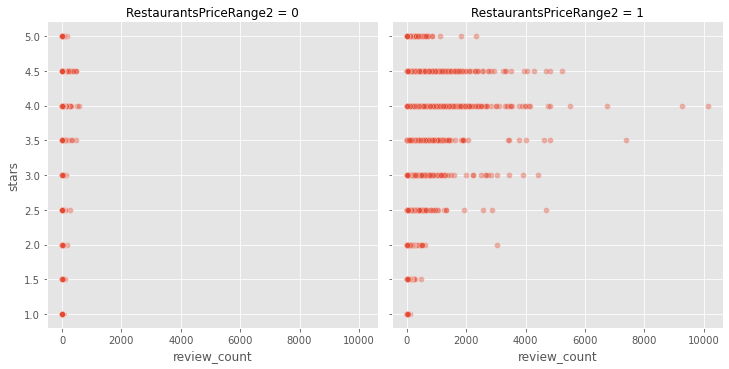

<Figure size 576x576 with 0 Axes>

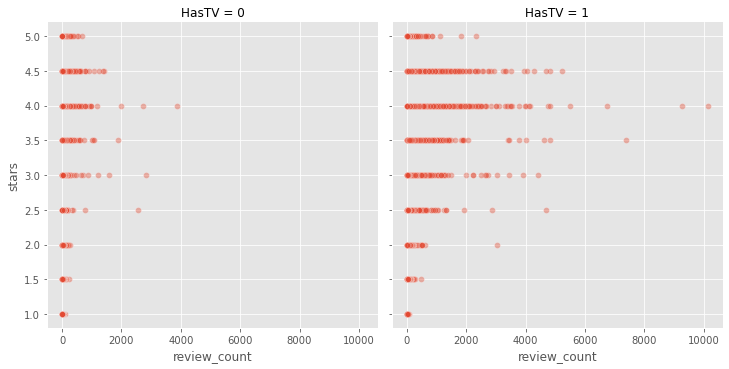

<Figure size 576x576 with 0 Axes>

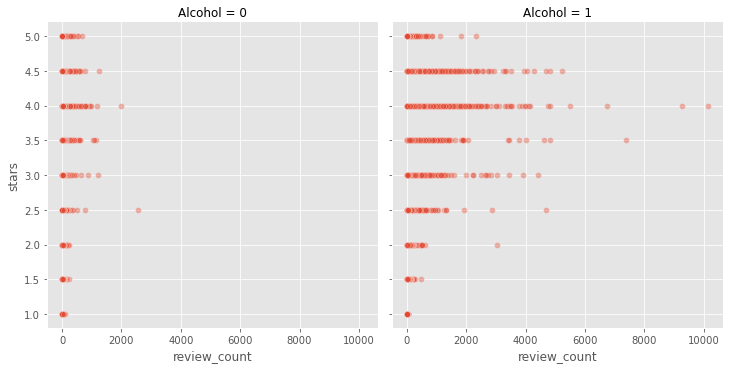

<Figure size 576x576 with 0 Axes>

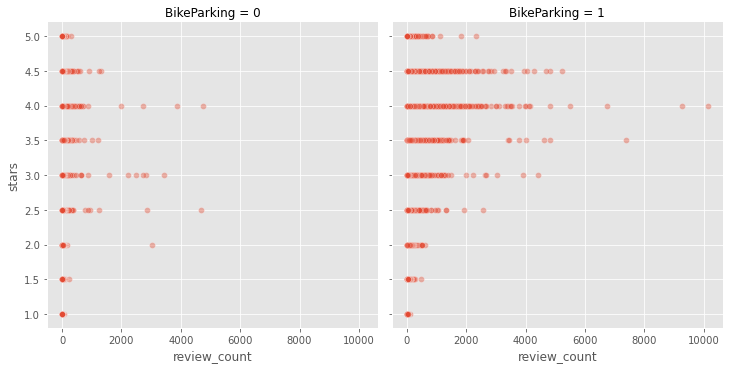

<Figure size 576x576 with 0 Axes>

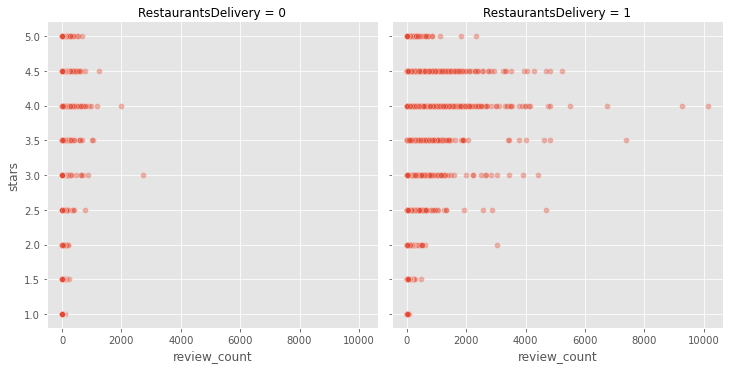

<Figure size 576x576 with 0 Axes>

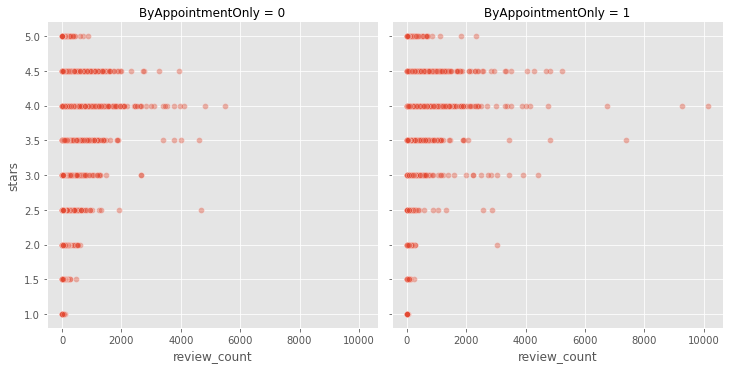

<Figure size 576x576 with 0 Axes>

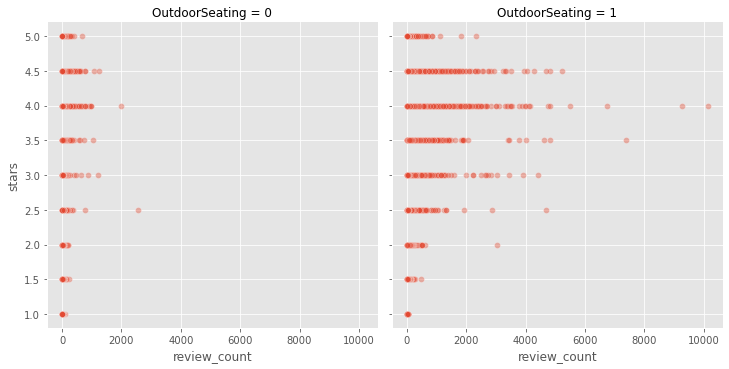

<Figure size 576x576 with 0 Axes>

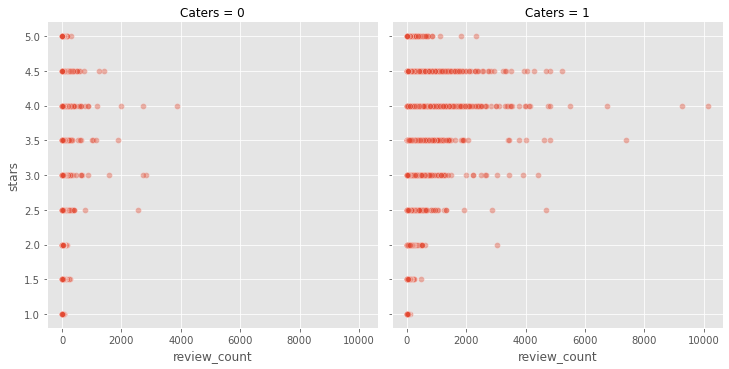

<Figure size 576x576 with 0 Axes>

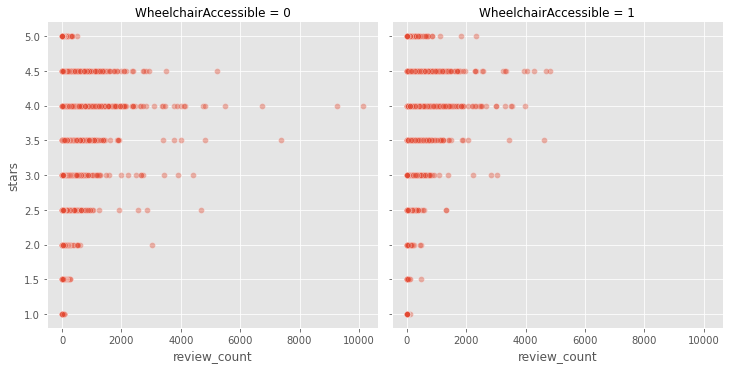

<Figure size 576x576 with 0 Axes>

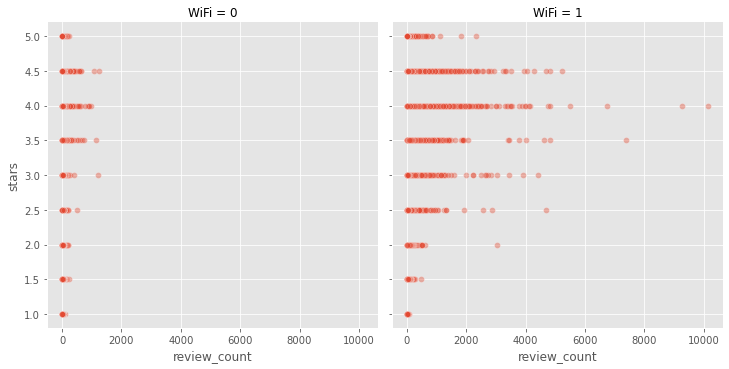

<Figure size 576x576 with 0 Axes>

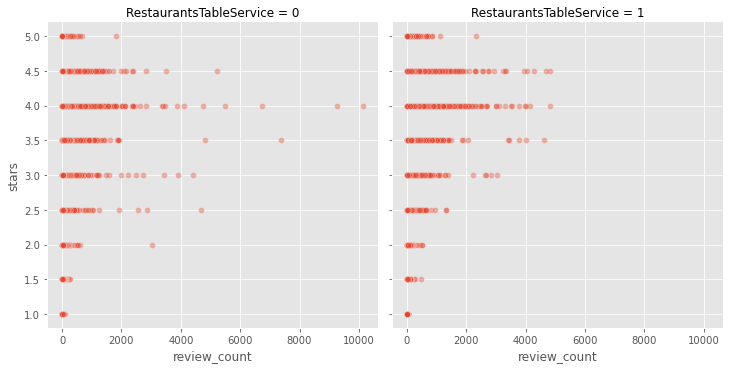

<Figure size 576x576 with 0 Axes>

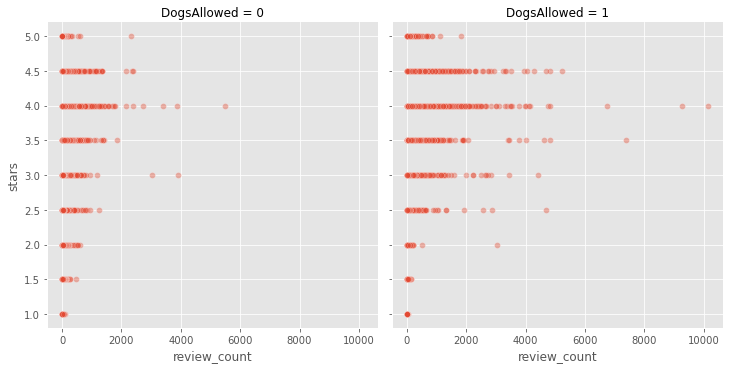

<Figure size 576x576 with 0 Axes>

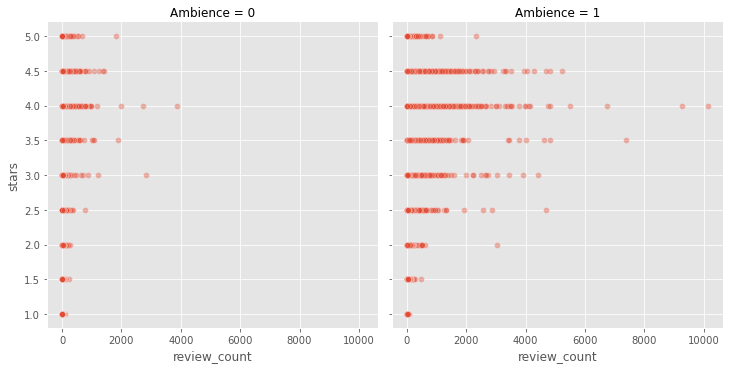

<Figure size 576x576 with 0 Axes>

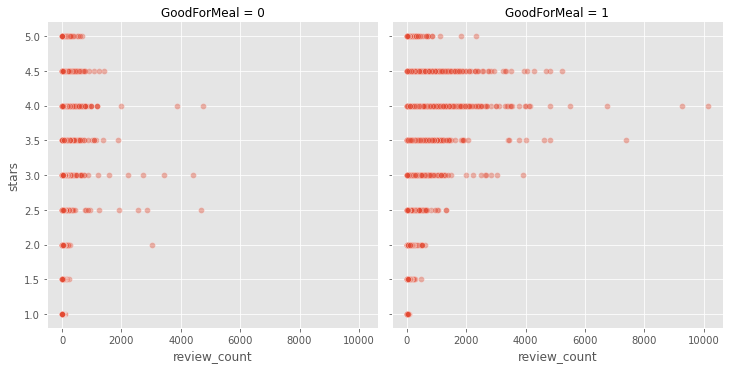

<Figure size 576x576 with 0 Axes>

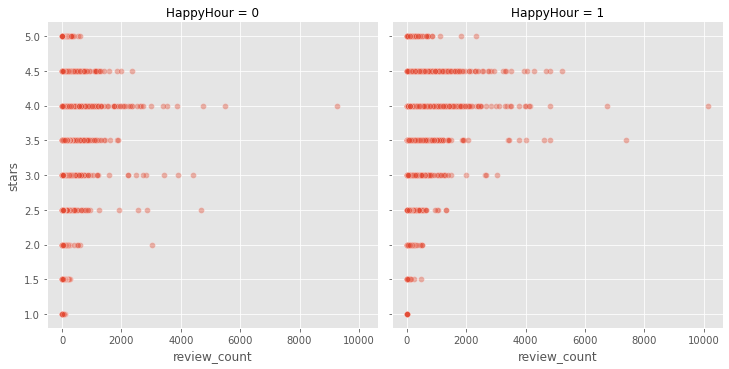

<Figure size 576x576 with 0 Axes>

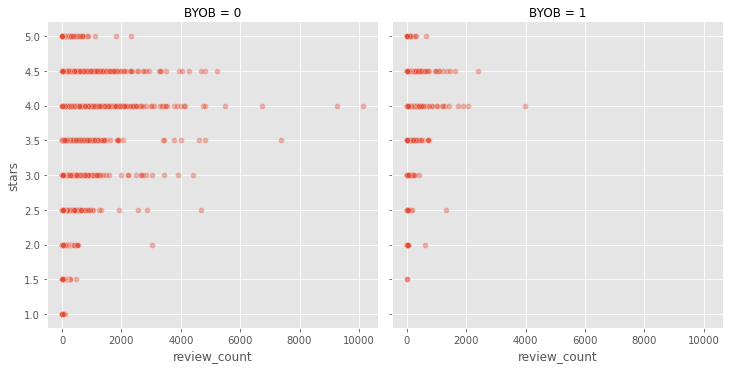

<Figure size 576x576 with 0 Axes>

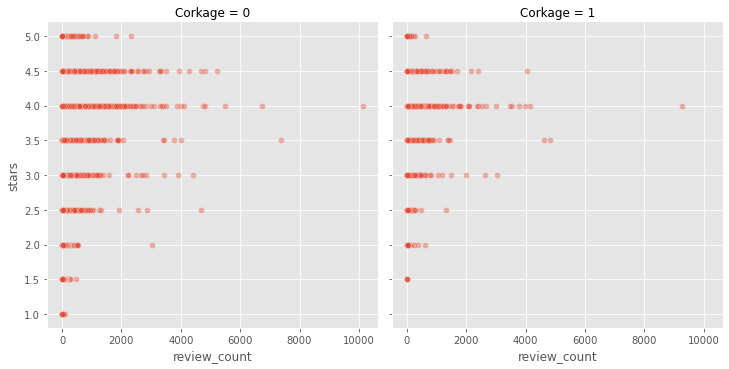

<Figure size 576x576 with 0 Axes>

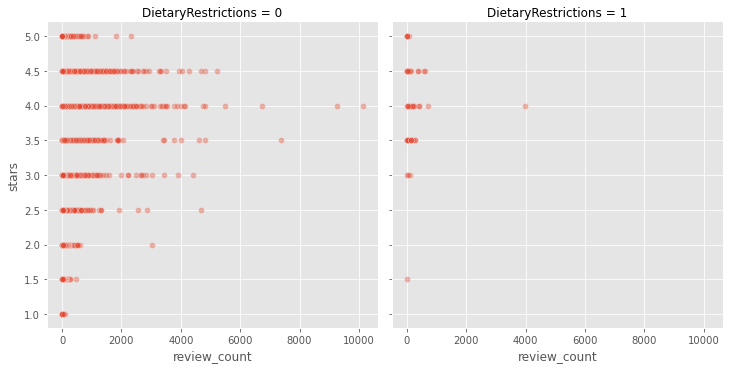

<Figure size 576x576 with 0 Axes>

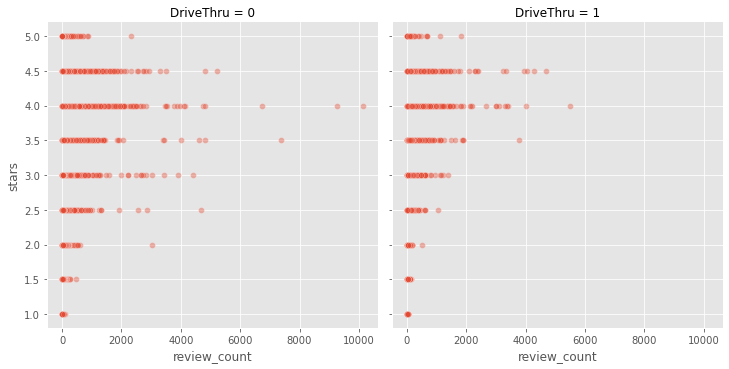

<Figure size 576x576 with 0 Axes>

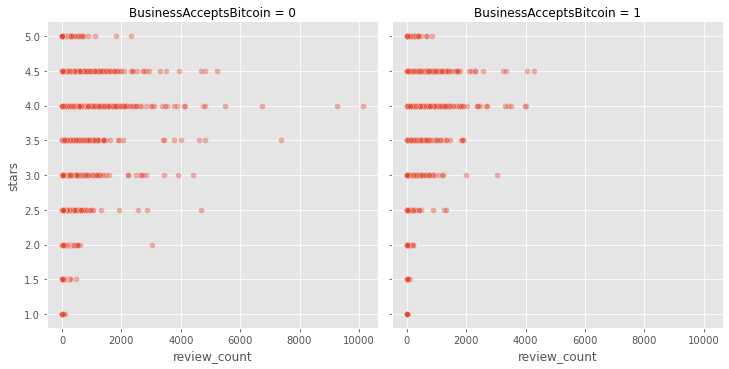

<Figure size 576x576 with 0 Axes>

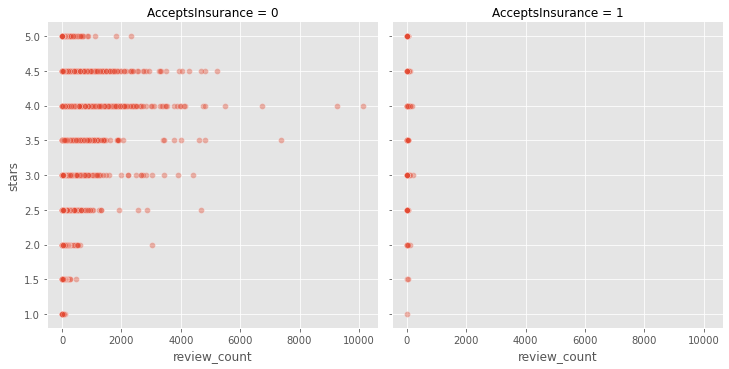

<Figure size 576x576 with 0 Axes>

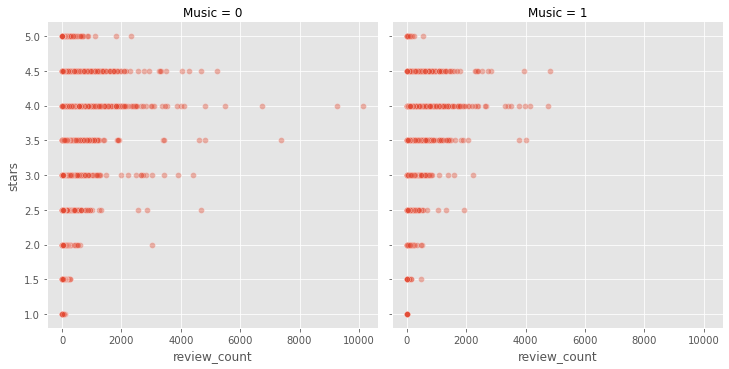

<Figure size 576x576 with 0 Axes>

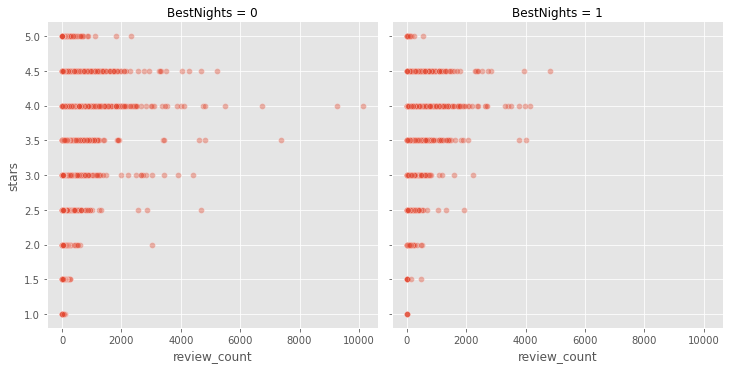

<Figure size 576x576 with 0 Axes>

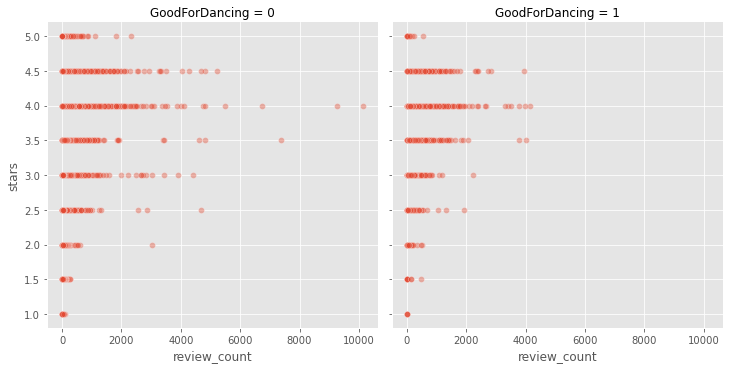

<Figure size 576x576 with 0 Axes>

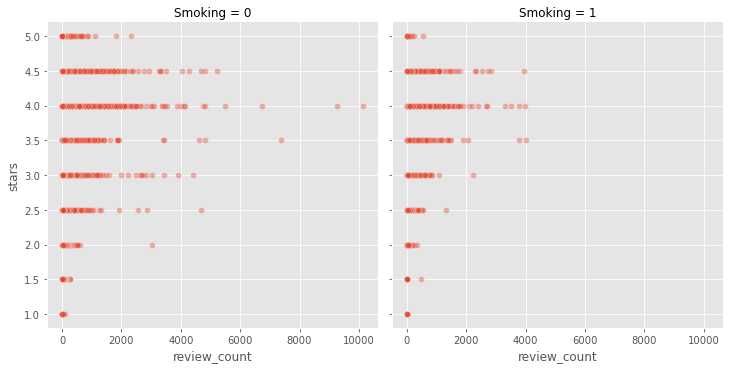

<Figure size 576x576 with 0 Axes>

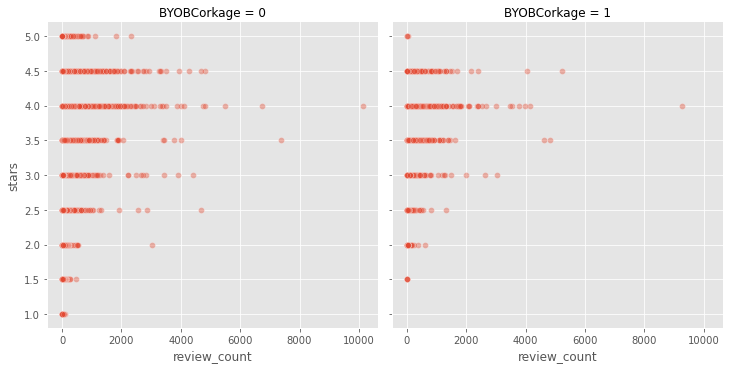

<Figure size 576x576 with 0 Axes>

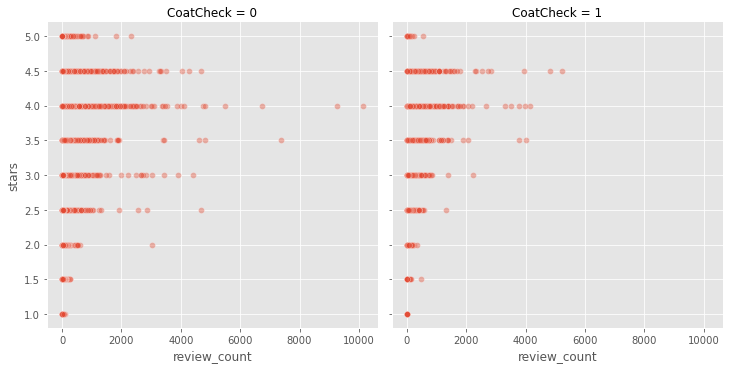

<Figure size 576x576 with 0 Axes>

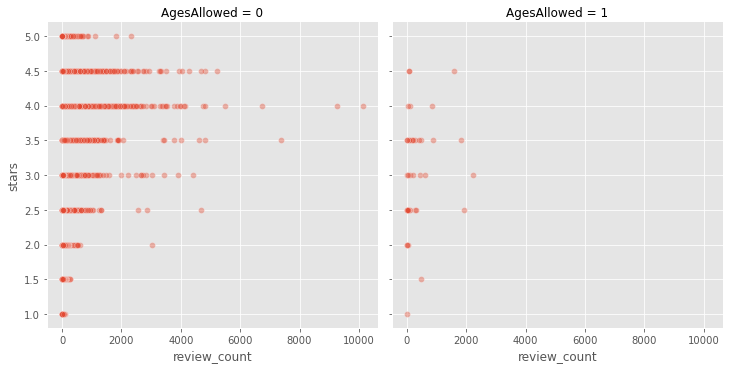

<Figure size 576x576 with 0 Axes>

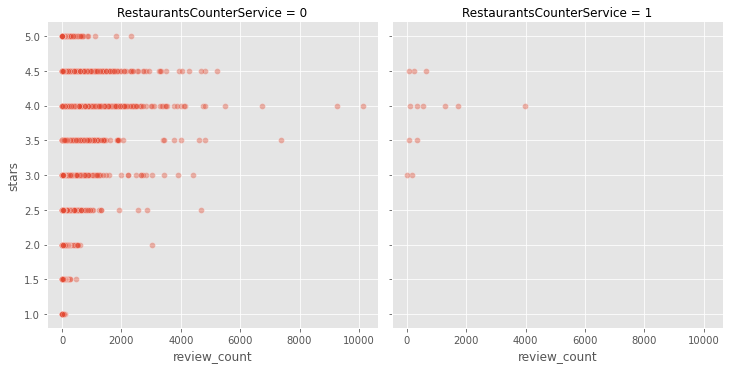

<Figure size 576x576 with 0 Axes>

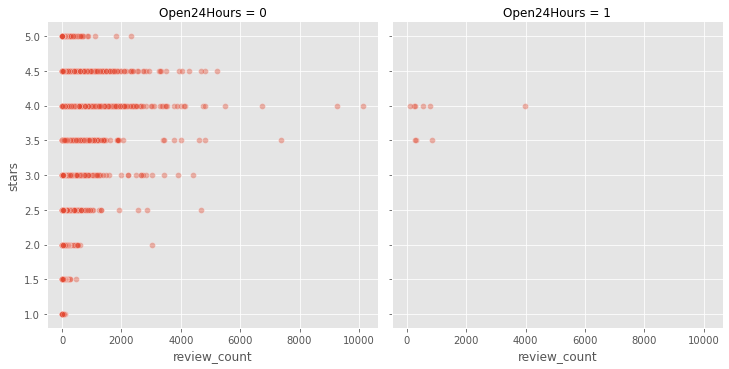

<Figure size 576x576 with 0 Axes>

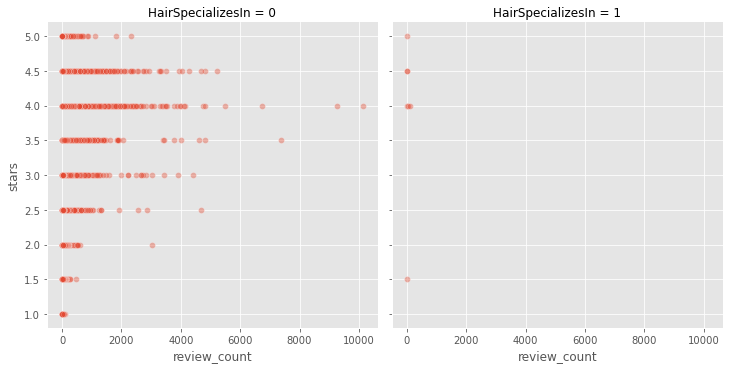

In [22]:
def plot(feature):
    plt.figure(figsize=(8, 8))
    sns.relplot(data=business_df, y='stars', x='review_count', col=feature, alpha=.4)

bool_features = []
for tup in make_query("PRAGMA table_info(businesses)"):
    if tup[2]=='BOOLEAN':
        bool_features.append(tup[1])

for feature in bool_features:
    plot(feature)

- Restaurants with Attire have higher ratings and more higher review count hence more popular than those without Attire.
- Restaurants with TakeOut, AcceptCreditCard, GoodForKids, Reservation, GoodForGroups, BusinessParking, HasTV, Alcohol, BikeParking, Delivery, OutdoorSeating, WiFi, Ambience, DogsAllowed, GoodForDancing, CoatCheck, CounterService show similar trend.
- Restaurnts with NoiseLevel also have higher avg ratings, this could be because they are located in prime locations.
- ByAppointmentOnly restaurants show roughly similar trend to Not ByAppointmentOnly restaurants.
- Restaurants with Outdoor Seating have better ratings and higher review count than those without OutdoorSeating. Hence restaurants with OutdoorSeating are more popular.
- Restaurants which are WheelChairAccessible do not perform better than those who aren't.
- Restaurants with WiFi are also more popular than those without.
- Some restaurants without TableService have higher reviewCount than those with.
- Restaurants with Dogs allowed also appear more popular.
- A/c to plot, Ambience plays a big role in a restaurants rating and review count. Those with ambience are more popular.
- Plots for restaurants with HappyHour, DriveThrough, Music, BestNights or AcceptsBitcoin do not differ significantly than those without.
- Restaurants without DietaryRestrictions are more highly rated than those with. 
- Restaurants with Open24Hours=0 are underrepresented.

Text(0, 0.5, 'Count')

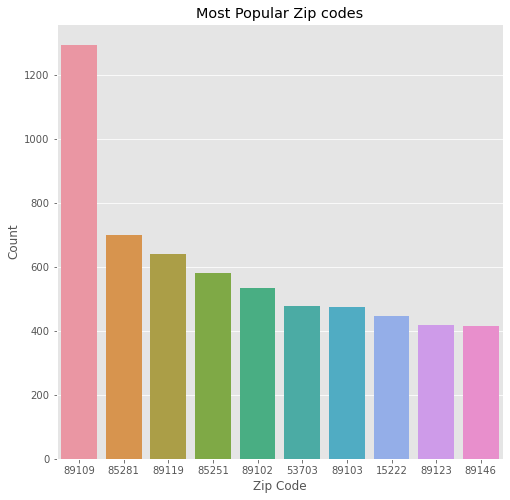

In [23]:
plt.figure(figsize=(8,8))
top_10_zip = business_df.postal_code.value_counts()[:10]
sns.barplot(x=top_10_zip.index, y=top_10_zip.values)
ax = plt.gca()
ax.set_title('Most Popular Zip codes')
ax.set_xlabel('Zip Code')
ax.set_ylabel('Count')


Our data has most number of businesses from zip code 89109 (Las Vegas). This can be verified on map.

[Text(0.5, 0, 'Restaurant'), Text(0, 0.5, 'Review Count')]

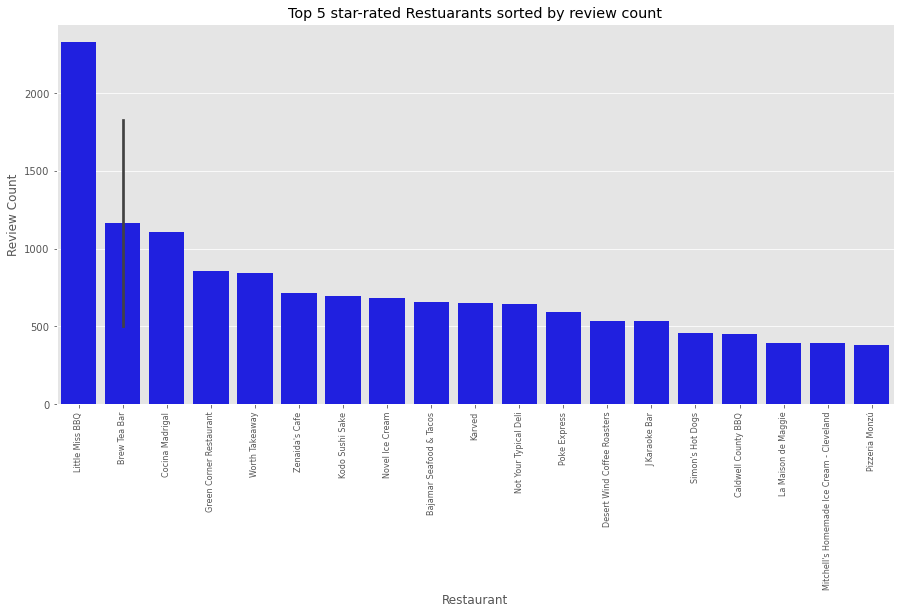

In [24]:
toprating_df = business_df[business_df["stars"]==5]
toprating_df = toprating_df.sort_values('review_count', ascending=False).head(20)

plt.figure(figsize=(15,7))
p = sns.barplot(x='name', y="review_count", data=toprating_df,color="b")
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("Top 5 star-rated Restuarants sorted by review count")
p.set(xlabel="Restaurant", ylabel="Review Count")

Restaurant businesses with ratings=5 and highest review counts

[Text(0.5, 0, 'Restaurant'), Text(0, 0.5, 'Rating')]

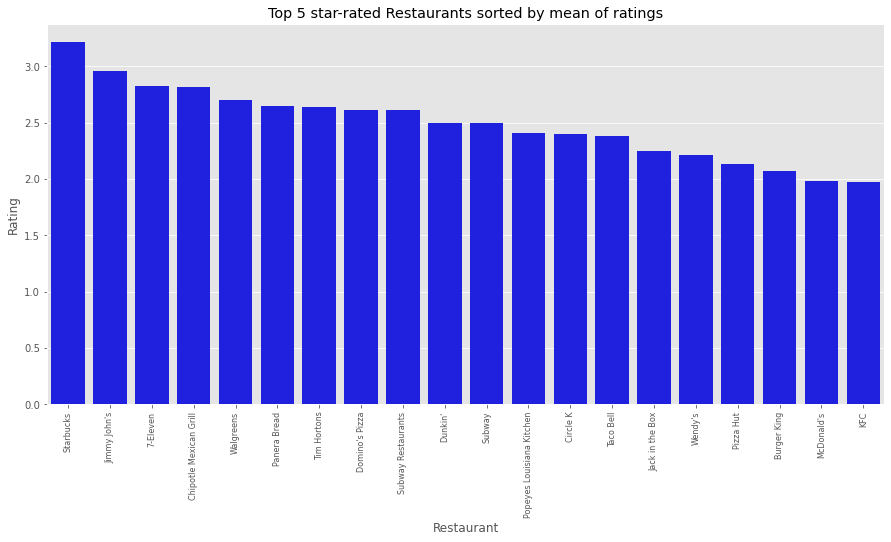

In [25]:
df_restaurants = business_df.name.value_counts().index[:20].tolist()
df_top = business_df.loc[business_df['name'].isin(df_restaurants)]
mean_df = df_top.groupby('name')['stars'].mean()
meanrating_df = mean_df.reset_index()
topmean_rating_df = meanrating_df.sort_values('stars', ascending=False).head(20)

plt.figure(figsize=(15,7))
p = sns.barplot(x='name', y="stars",data=topmean_rating_df, color="b")
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("Top 5 star-rated Restaurants sorted by mean of ratings")
p.set(xlabel="Restaurant", ylabel="Rating")

Restaurant businesses with highest mean scores of ratings, with 20 occurences

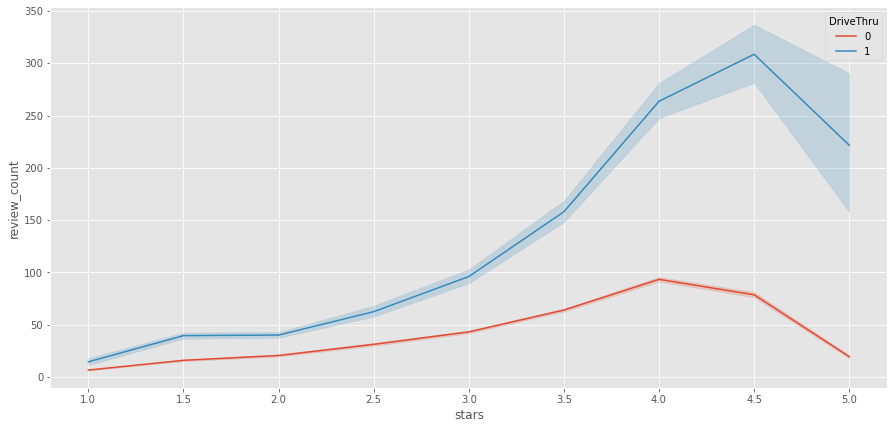

In [26]:
plt.figure(figsize=(15,7))
sns.lineplot(x=business_df["stars"],y=business_df["review_count"],hue=business_df["DriveThru"],ci=80)
plt.legend(bbox_to_anchor=(1.00, 1), title ="DriveThru")
plt.show()


Restaurants with Drive Through have higher ratings and higher review count. Hence are more popular.

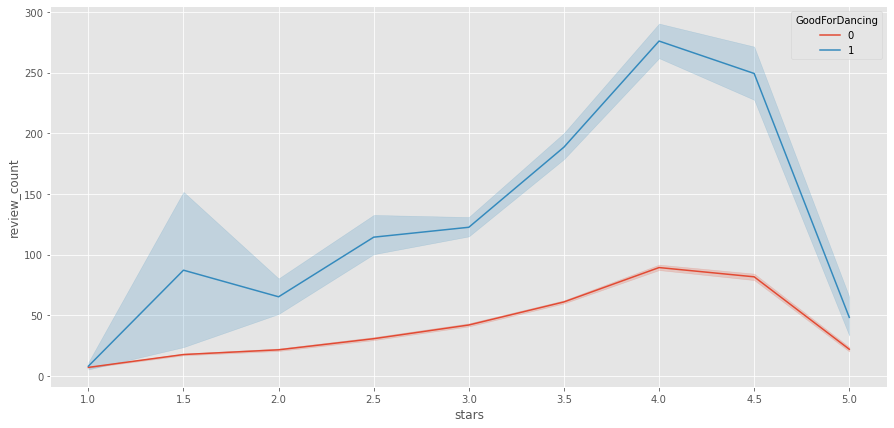

In [27]:
plt.figure(figsize=(15,7))
sns.lineplot(x=business_df["stars"],y=business_df["review_count"],hue=business_df["GoodForDancing"],ci=80)
plt.legend(bbox_to_anchor=(1.00, 1), title ="GoodForDancing")
plt.show()

Restaurants GoodForDancing also appear more popular.

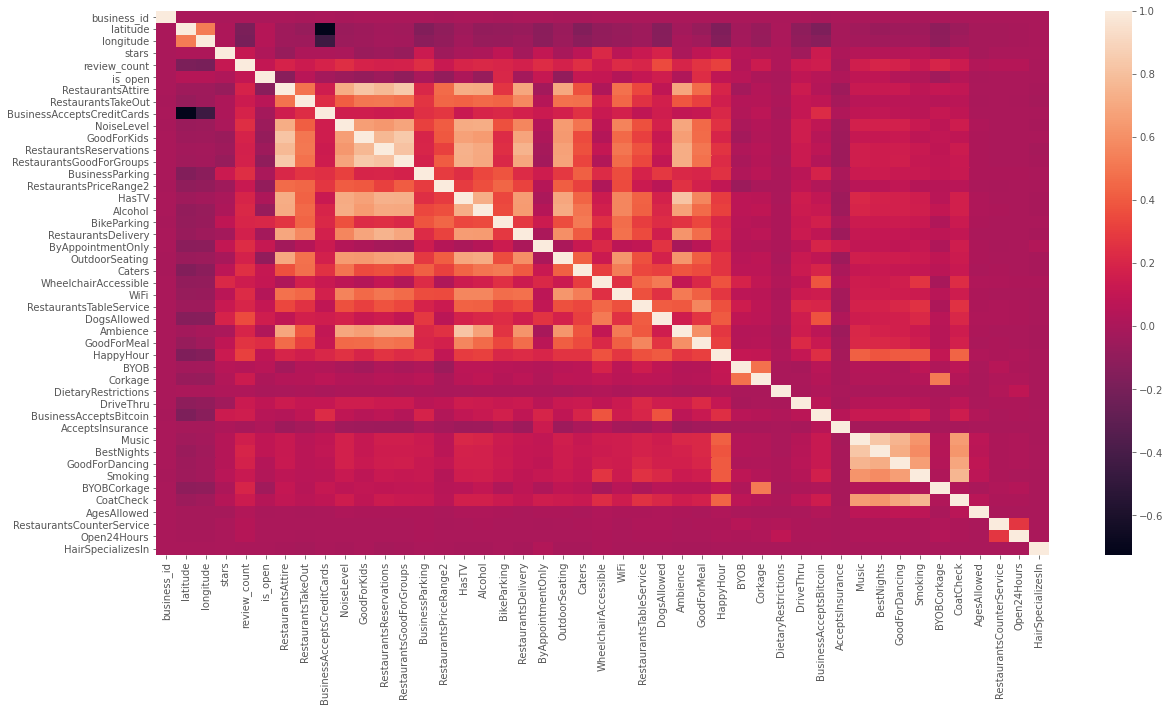

In [28]:
plt.figure(figsize=(20,10))
sns.heatmap(business_df.corr(),annot=False)
plt.show()

We see some correlations roughly at the centre of heatmap. They could be due to redundant features like a Restaurant with CarParking will most likely have BikeParking, or because high end restaurants have most of the listed features.

## Conclusion
- We studied various plots. 
- Restaurants with TakeOut, AcceptCreditCard, GoodForKids, Reservation, GoodForGroups, BusinessParking, HasTV, Alcohol, BikeParking, Delivery, OutdoorSeating, WiFi, Ambience, DogsAllowed, GoodForDancing, CoatCheck, CounterService, Attire are more popular in general.


#### Links
[1. Getting Data Ready](https://github.com/yashrajwani/Restaurant-Recommendation-System/blob/main/1.%20Getting%20Data%20Ready.ipynb)

[3. Modelling](https://github.com/yashrajwani/Restaurant-Recommendation-System/blob/main/3.%20Modelling%20(Recommendation%20System).ipynb)